In [1]:
import sys
sys.path.append('../')
from msBO import MultiStateBO
from msBO.objective import BPMvar_minimization
sys.path.append('../../machineIO/')
from machineIO import construct_machineIO, StatefulOracleEvaluator
from machineIO.preset import get_limits

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from epics import caget, caget_many, caput_many
from phantasy import fetch_data
import datetime
from phantasy import ensure_set, fetch_data

# import importlib, msBO  # or from boom import msBO if that's your import
# importlib.reload(msBO)

In [2]:
n_init = 16
n_each = 4
n_states = 3
n_iter = 3

In [3]:
SCS = caget("ACS_DIAG:DEST:ACTIVE_ION_SOURCE")
ion = caget("FE_ISRC"+str(SCS)+":BEAM:ELMT_BOOK")
Q = caget("FE_ISRC"+str(SCS)+":BEAM:Q_BOOK")
A = caget("FE_ISRC"+str(SCS)+":BEAM:A_BOOK")
# AQ = caget("FE_ISRC2:BEAM:MOVRQ_BOOK")
AQ = A/Q
ion = str(A)+ion+str(Q)
print('SCS'+str(SCS), ion, 'A/Q=',AQ)

SCS2 124Xe26 A/Q= 4.769230769230769


In [4]:
now0 = datetime.datetime.now()
fname = now0.strftime('%Y%m%d_%H%M')+'['+ion+'][msBO]test'
fname

'20260110_0345[124Xe26][msBO]test'

### construct machineIO

In [5]:
mIO = construct_machineIO()

In [6]:
mIO.__dict__

{'_ensure_set_timeout': 20,
 '_ensure_set_timewait_after_ramp': 0.3,
 '_fetch_data_time_span': 2.0,
 '_sample_interval': 0.2,
 '_verbose': False,
 '_n_popup_ramping_issue': 0,
 '_history_lock': <unlocked _thread.lock object at 0x7fbcd2186d80>,
 'history': [],
 'test': False,
 'isOK_PVs': ['ACS_DIAG:CHP:STATE_RD'],
 'isOK_vals': [3],
 '_ensure_set': <machineIO.construct_machineIO._ensure_set_wrapper at 0x7fbcd2186d10>,
 '_fetch_data': <machineIO.construct_machineIO._fetch_data_wrapper at 0x7fbcd2366c10>}

In [7]:
n_state = 3
ramping_time = 1
BO_comp_time = 10
dt = mIO._ensure_set_timewait_after_ramp + mIO._fetch_data_time_span + ramping_time + BO_comp_time
print(f'expected run time: {int((n_init*n_state + n_iter*n_state*n_each)*dt/60)} min')
print(f'expected number of data: {n_init*n_state + n_iter*n_state*n_each}')

expected run time: 18 min
expected number of data: 84


### control knobs

In [8]:
control_CSETs = [
    'FS1_CSS:PSC2_D2351:I_CSET',
    'FS1_CSS:PSC1_D2351:I_CSET',
    'FS1_CSS:PSC2_D2381:I_CSET',
    'FS1_CSS:PSC1_D2381:I_CSET',
#     'FS1_BBS:PSC2_D2412:I_CSET',
#     'FS1_BBS:PSC1_D2412:I_CSET',
#     'FS1_BBS:PSC2_D2476:I_CSET',
#     'FS1_BBS:PSC1_D2476:I_CSET',
    'FS1_BBS:PSQ_D2416:I_CSET',
    'FS1_BBS:PSS_D2419:I_CSET',
    'FS1_BMS:PSC2_D2507:I_CSET',
    'FS1_BMS:PSC1_D2507:I_CSET',
#     'FS1_BMS:PSC2_D2534:I_CSET',
#     'FS1_BMS:PSC1_D2534:I_CSET',
]
control_RDs = [pv.replace('CSET','RD') for pv in control_CSETs]


control_ref = np.array(caget_many(control_CSETs))
control_rd_ref = np.array(caget_many(control_RDs))
control_tols_ref = 2*np.abs(control_ref - control_rd_ref)

control_tols = []
control_min = []
control_max = []
i = 0
for v, PV in zip(control_ref,control_CSETs):
    if ':PSC' in PV:
        control_min.append(v - 2)
        control_max.append(v + 2)
        control_tols.append(max(0.1,control_tols_ref[i]))
    elif ':PSQ_' in PV:
        control_min.append(v*0.99)
        control_max.append(v*1.01)
        control_tols.append(max(0.1,control_tols_ref[i]))
    elif ':PSS_' in PV:
        control_min.append(v*0.3)
        control_max.append(v*1.7)
        control_tols.append(max(0.05,control_tols_ref[i]))
    else:
        raise ValueError(f'control min/max cannot be determined automatically for {PV}')
    i+=1
        
        
##== Manually set decision bounds and tolerance
# control_min = [ -5, -5, -5, -5]
# control_max = [  5,  5,  5,  5]
# control_tols = [0.2,0.2,0.2,0.2]

assert len(control_CSETs) == len(control_min) == len(control_max) == len(control_tols)
control_Lo_limit, control_Hi_limit = get_limits(control_CSETs)
control_min = np.clip(control_min, a_min = control_Lo_limit, a_max = None)
control_max = np.clip(control_max, a_min = None, a_max = control_Hi_limit)
assert np.all(control_max > control_min)

pd.DataFrame(np.array([control_ref,control_min,control_max,control_tols,control_Lo_limit,control_Hi_limit]).T,
             index=control_CSETs, 
             columns=['current value','decision min','decision max','tol','LoLim','HiLim'])

,current value,decision min,decision max,tol,LoLim,HiLim
FS1_CSS:PSC2_D2351:I_CSET,0.000,-2.00000,2.00000,0.100,-39.0,39.0
FS1_CSS:PSC1_D2351:I_CSET,0.000,-2.00000,2.00000,0.100,-19.0,19.0
FS1_CSS:PSC2_D2381:I_CSET,-2.358,-4.35800,-0.35800,0.100,-39.0,39.0
FS1_CSS:PSC1_D2381:I_CSET,0.622,-1.37800,2.62200,0.100,-19.0,19.0
FS1_BBS:PSQ_D2416:I_CSET,154.225,152.68275,155.76725,0.236,0.0,265.0
FS1_BBS:PSS_D2419:I_CSET,1.609,0.48270,2.73530,0.050,0.0,4.7
FS1_BMS:PSC2_D2507:I_CSET,3.657,1.65700,5.65700,0.100,-39.0,39.0
FS1_BMS:PSC1_D2507:I_CSET,-0.470,-2.47000,1.53000,0.100,-19.0,19.0


In [9]:
control_couplings = {
    'FS1_BBS:PSQ_D2416:I_CSET':
        {
            'CSETs' :['FS1_BBS:PSQ_D2424:I_CSET','FS1_BBS:PSQ_D2463:I_CSET','FS1_BBS:PSQ_D2472:I_CSET'],
            'RDs'   :[],
            'tols'  :[],
            'coeffs':[],
        },
     'FS1_BBS:PSS_D2419:I_CSET':
        {
            'CSETs' :['FS1_BBS:PSS_D2469:I_CSET'],
            'RDs'   :[],
            'tols'  :[],
            'coeffs':[],
        },
}

for pv, val in control_couplings.items():
    x = caget(pv)
    y = np.array(caget_many(val['CSETs']))
    ipv = control_CSETs.index(pv)
    tol = control_tols[ipv]
    val['RDs'] = [pv.replace('CSET','RD') for pv in val['CSETs']]
    val['tols'] = [tol]*len(val['CSETs'])
    val['coeffs'] = y/x
    
control_couplings

{'FS1_BBS:PSQ_D2416:I_CSET': {'CSETs': ['FS1_BBS:PSQ_D2424:I_CSET',
   'FS1_BBS:PSQ_D2463:I_CSET',
   'FS1_BBS:PSQ_D2472:I_CSET'],
  'RDs': ['FS1_BBS:PSQ_D2424:I_RD',
   'FS1_BBS:PSQ_D2463:I_RD',
   'FS1_BBS:PSQ_D2472:I_RD'],
  'tols': [0.23599999999999, 0.23599999999999, 0.23599999999999],
  'coeffs': array([0.48855244, 0.48855244, 1.        ])},
 'FS1_BBS:PSS_D2419:I_CSET': {'CSETs': ['FS1_BBS:PSS_D2469:I_CSET'],
  'RDs': ['FS1_BBS:PSS_D2469:I_RD'],
  'tols': [0.05],
  'coeffs': array([1.])}}

### state definition

In [10]:
state_CSETs  = ['FS1_BBS:CSEL_D2405:CTR_MTR.VAL']
state_RDs    = ['FS1_BBS:CSEL_D2405:CTR_MTR.RBV']
state_tols   = [0.1]*len(state_CSETs)
state_val0   = caget_many(state_CSETs)
state_key_vals  = {'48+':[ 16.0],
                   '49+':[ -1.0],
                   '50+':[-18.7]}
states = list(state_key_vals.keys())
n_states = len(states)
state_key_vals

{'48+': [16.0], '49+': [-1.0], '50+': [-18.7]}

### monitors

In [11]:
# monitor_BPMs = ['FS1_BMS:BPM_D2502','FS1_BMS:BPM_D2537','FS1_BMS:BPM_D2587','FS1_BMS:BPM_D2600']
monitor_BPMs = ['FS1_BMS:BPM_D2502','FS1_BMS:BPM_D2537']
monitor_RDs = []
for bpm in monitor_BPMs:
    monitor_RDs += [bpm+':XPOS_RD',bpm+':YPOS_RD',bpm+':MAG_RD']
#     monitor_RDs += [bpm+':YPOS_RD',bpm+':MAG_RD']

### Define Oracle 
# WARN!  This cell may change state!

In [12]:
bpm_posRDs = [pv for pv in monitor_RDs if 'POS_RD' in pv]
bpm_magRDs = [pv for pv in monitor_RDs if 'MAG_RD' in pv]

BPM_MAGs_ref = {}
for state, goal in state_key_vals.items():
#     ret = ensure_set(state_CSETs,state_RDs,goal,state_tols,timeout=30)
    input(f"{state_CSETs},{goal}")
    val, _ = fetch_data(bpm_magRDs,5)
    BPM_MAGs_ref[state] = val
# BPM_MAGs_ref = {
#     '28+': np.array([0.00736107, 0.00836198, 0.00703028]),
#     '29+': np.array([0.01749245, 0.01971336, 0.01654423])
# }

['FS1_BBS:CSEL_D2405:CTR_MTR.VAL'],[16.0]
[03:46:24.935] WARNING: phantasy.~.epics_tools: Established 2 PVs in 14.3 ms.
['FS1_BBS:CSEL_D2405:CTR_MTR.VAL'],[-1.0]
[03:46:47.543] WARNING: phantasy.~.epics_tools: Established 2 PVs in 0.1 ms.
['FS1_BBS:CSEL_D2405:CTR_MTR.VAL'],[-18.7]
[03:47:11.143] WARNING: phantasy.~.epics_tools: Established 2 PVs in 0.0 ms.


In [13]:
def BPM_MAG_obj(df,s):
    df['BPM:MAG_min_ratio'] = (df[bpm_magRDs].values/BPM_MAGs_ref[s][None,:]).min()
    return df

In [14]:
oracle_key_names = {'x':control_RDs,
                    'y':bpm_posRDs + ['BPM:MAG_min_ratio']}
oracle_key_names

{'x': ['FS1_CSS:PSC2_D2351:I_RD',
  'FS1_CSS:PSC1_D2351:I_RD',
  'FS1_CSS:PSC2_D2381:I_RD',
  'FS1_CSS:PSC1_D2381:I_RD',
  'FS1_BBS:PSQ_D2416:I_RD',
  'FS1_BBS:PSS_D2419:I_RD',
  'FS1_BMS:PSC2_D2507:I_RD',
  'FS1_BMS:PSC1_D2507:I_RD'],
 'y': ['FS1_BMS:BPM_D2502:XPOS_RD',
  'FS1_BMS:BPM_D2502:YPOS_RD',
  'FS1_BMS:BPM_D2537:XPOS_RD',
  'FS1_BMS:BPM_D2537:YPOS_RD',
  'BPM:MAG_min_ratio']}

### check control couplings 

In [15]:
oracleEvaluator = StatefulOracleEvaluator(
    mIO,
    control_CSETs= control_CSETs,
    control_RDs  = control_RDs,
    control_tols = control_tols,
    state_CSETs  = state_CSETs,
    state_RDs    = state_RDs,
    state_tols   = state_tols,
    state_key_vals = state_key_vals,
    oracle_key_names = oracle_key_names,
    monitor_RDs  = monitor_RDs,
    control_couplings = control_couplings,
    state_df_manipulators = [BPM_MAG_obj],
)

# Define Composite Object

In [16]:
n_state = len(states)
n_task = len(bpm_posRDs)+1
composite_objective_function = BPMvar_minimization(S=n_state, J=n_task)

# Define msBO

In [17]:
local_optimization = False
acq_type = 'EI'
fix_acq_state = False

msbo = MultiStateBO(
    states = states,
    tasks  = oracle_key_names['y'], 
    control_min = control_min,
    control_max = control_max,
    multistate_oracle_evaluator = oracleEvaluator,
    composite_objective_function = composite_objective_function,
    local_bound_size = 0.2*(np.asarray(control_max) - np.asarray(control_min))
    )

[03:47:17.593] WARNING: phantasy.~.epics_tools: Established 33 PVs in 96.3 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


In [18]:
# run msBO

In [19]:
msbo.init(n_init=n_init, local_optimization=local_optimization)
for i_iter in range(n_iter):
    if i_iter%2==0:
        states_order = states[::-1]
    else:
        states_order = states
    for s in states_order:
        print(i_iter, s)
        for i_each in range(n_each):
            msbo.step(s=s, local_optimization=local_optimization, acq_type=acq_type, fix_acq_state=fix_acq_state)

set FS1_BBS:CSEL_D2405:CTR_MTR.VAL to 16.0
[03:47:20.965] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


set FS1_BBS:CSEL_D2405:CTR_MTR.VAL to 16.0
[03:48:03.294] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:48:11.016] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.2 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:48:21.199] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:48:44.432] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:48:49.099] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.5 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:48:58.912] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:49:08.499] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:49:13.489] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:49:22.895] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.3 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:49:31.797] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:49:40.989] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:49:51.119] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:49:59.822] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:50:08.800] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:50:19.016] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.2 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


set FS1_BBS:CSEL_D2405:CTR_MTR.VAL to -1.0
[03:51:29.797] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:51:35.210] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:51:43.826] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.2 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:51:53.798] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:52:04.604] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:52:09.596] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:52:18.491] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:52:28.696] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:52:33.307] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.2 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:52:42.928] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:52:51.829] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.2 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:53:00.814] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.2 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:53:11.116] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:53:19.603] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:53:29.221] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.2 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:53:38.600] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


set FS1_BBS:CSEL_D2405:CTR_MTR.VAL to -18.7
[03:54:09.003] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:54:13.901] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:54:23.003] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:54:32.615] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:54:41.799] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:54:46.696] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:54:54.909] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:55:02.993] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:55:07.998] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:55:17.001] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:55:25.906] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:55:35.115] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:55:44.806] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:55:53.292] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:56:03.307] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.3 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:56:12.796] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):
/user/shared/ap-ml/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:644.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


0 50+
[03:56:33.795] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:57:00.617] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:57:12.592] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:57:23.169] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


0 49+
set FS1_BBS:CSEL_D2405:CTR_MTR.VAL to -1.0
[03:58:32.193] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:58:44.475] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:58:56.896] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[03:59:05.725] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


0 48+
set FS1_BBS:CSEL_D2405:CTR_MTR.VAL to 16.0
[03:59:55.701] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.5 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[04:00:15.214] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[04:00:27.557] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[04:00:43.338] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


1 48+
[04:00:54.998] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.2 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[04:01:06.938] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.2 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[04:01:22.045] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[04:01:40.816] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.2 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


1 49+
set FS1_BBS:CSEL_D2405:CTR_MTR.VAL to -1.0
[04:02:20.489] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[04:02:33.975] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[04:02:45.843] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[04:03:01.556] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


1 50+
set FS1_BBS:CSEL_D2405:CTR_MTR.VAL to -18.7
[04:03:56.675] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[04:04:08.586] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[04:04:18.686] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[04:04:35.808] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.2 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


2 50+
[04:04:51.605] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.2 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[04:05:08.464] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.2 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[04:05:20.508] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[04:05:31.686] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


2 49+
set FS1_BBS:CSEL_D2405:CTR_MTR.VAL to -1.0
[04:06:07.802] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[04:06:18.985] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.2 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[04:06:29.949] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[04:06:44.982] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


2 48+
set FS1_BBS:CSEL_D2405:CTR_MTR.VAL to 16.0
[04:07:28.055] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.2 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[04:07:41.909] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[04:07:58.392] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


[04:08:18.183] WARNING: phantasy.~.epics_tools: Established 33 PVs in 0.1 ms.


/user/shared/pkgs/boom/examples/../../machineIO/machineIO/construct_machineIO.py:182: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  while np.any(df[self.isOK_PVs].mean().values != self.isOK_vals):


In [20]:
now1 = datetime.datetime.now()

In [41]:
timedelta = now1-now0
timedelta

datetime.timedelta(seconds=1481, microseconds=804597)

In [42]:
1481/60

24.683333333333334

### visualize optimization result

(0.0, 1.0)

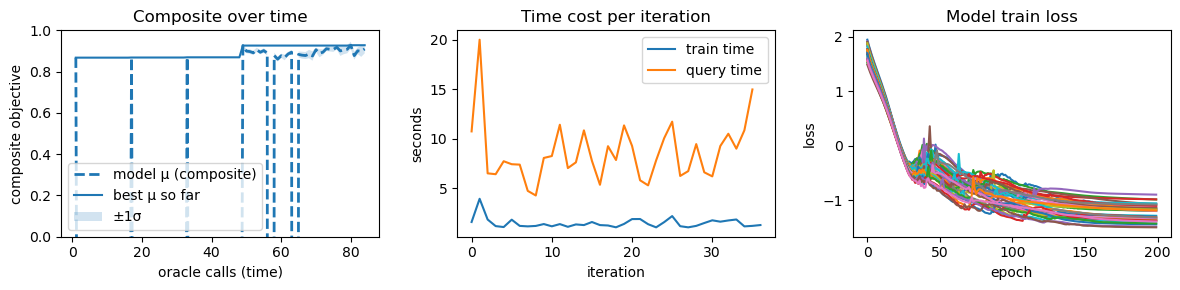

In [21]:
fig,ax, virtualObjMean = msbo.plot_composite_objective()
ax[0].set_ylim(0,1)

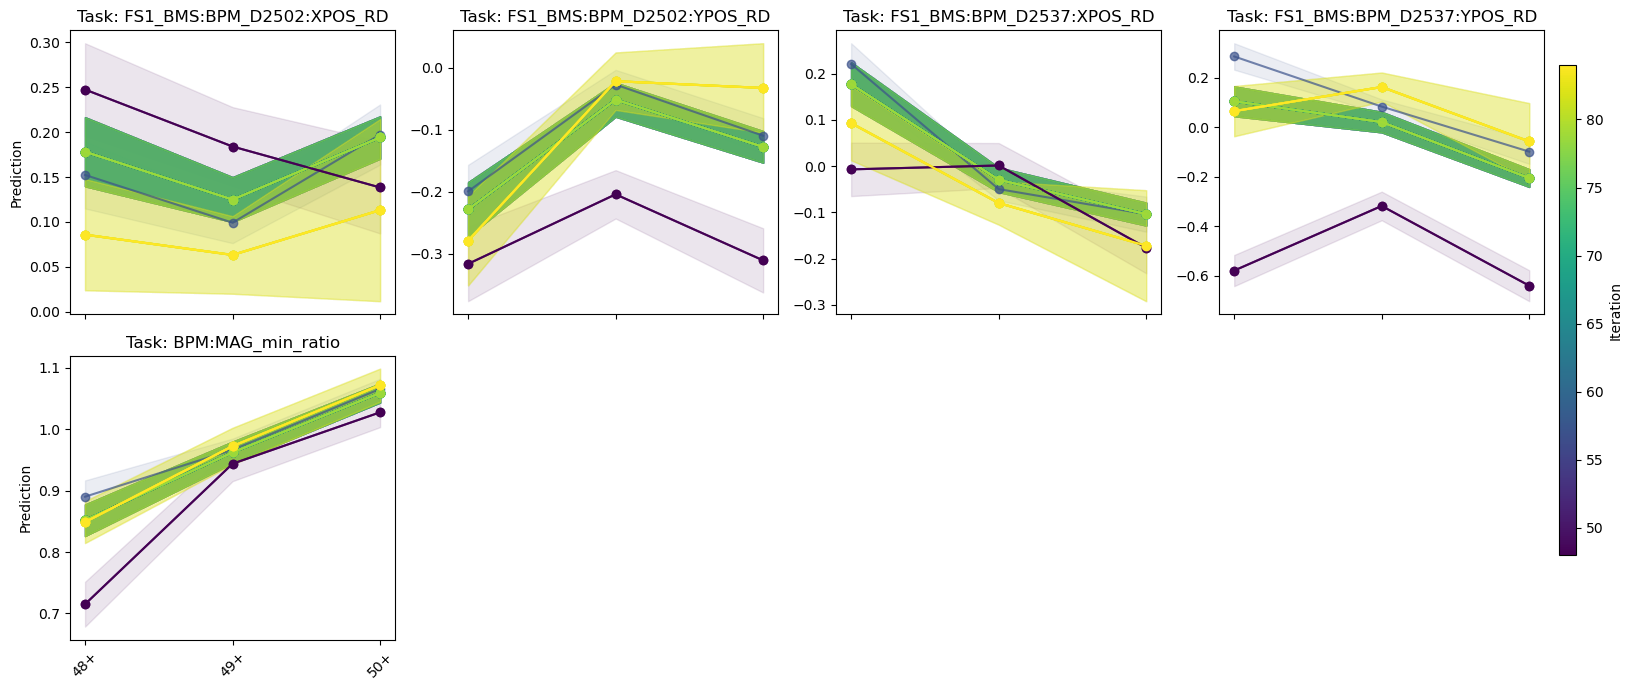

In [22]:
fig, axes = msbo.plot_state_predictions_history()

### set to best solution

In [31]:
x_best = msbo.history['predictions'][-1]['x_best']
x_best

array([ 0.00000000e+00, -1.03066364e-01, -2.42734000e+00,  6.45110000e-01,
        1.53848000e+02,  1.63955364e+00,  3.69810000e+00, -4.86900000e-01])

In [ ]:
caput_many(control_CSETs,x_best)

### restore states

In [ ]:
caput_many(state_CSETs,state_val0)

### restore control if optimization result is not good

In [ ]:
# caput_many(control_CSETs,control_ref)